In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
#import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load

In [2]:
#proton_selection = "SingleRP"
proton_selection = "MultiRP"

train_model = True
run_grid_search = True
save_model = True

In [3]:
def get_data( fileNames ):
    df_list = []
    df_counts_list = []

    for file_ in fileNames:
        print ( file_ )
        with h5py.File( file_, 'r' ) as f:
            print ( list(f.keys()) )
            dset = f['protons']
            print ( dset.shape )
            print ( dset[:,:] )

            dset_columns = f['columns']
            print ( dset_columns.shape )
            columns = list( dset_columns )
            print ( columns )
            columns_str = [ item.decode("utf-8") for item in columns ]
            print ( columns_str )

            dset_selections = f['selections']
            selections_ = [ item.decode("utf-8") for item in dset_selections ]
            print ( selections_ )

            dset_counts = f['event_counts']
            df_counts_list.append( pd.Series( dset_counts, index=selections_ ) )
            print ( df_counts_list[-1] )

            chunk_size = 1000000
            entries = dset.shape[0]
            start_ = list( range( 0, entries, chunk_size ) )
            stop_ = start_[1:]
            stop_.append( entries )
            print ( start_ )
            print ( stop_ )
            for idx in range( len( start_ ) ):
                print ( start_[idx], stop_[idx] )
                #print ( dset[ start_[idx] : stop_[idx] ] )
                df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
                df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                            'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                            'Xi', 'T', 'ThX', 'ThY', 'Time',
                            'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
                df_list.append( df_ )
                print ( df_list[-1].head() )
                print ( len( df_list[-1] ) )

    df_counts = df_counts_list[0]
    for idx in range( 1, len( df_counts_list ) ):
        df_counts = df_counts.add( df_counts_list[idx] )
    print ( df_counts )

    df = pd.concat( df_list )
    print ( df )
    
    return ( df_counts, df )

In [4]:
def process_data( df ):
    msk = ( df["InvMass"] >= 110. )

    msk1 = None
    msk2 = None
    if proton_selection == "SingleRP":
        # Single-RP in pixel stations
        msk1_arm = ( df["RPId1"] == 23 )
        msk2_arm = ( df["RPId1"] == 123 )
        df[ "XiMuMu" ] = np.nan
        df[ "XiMuMu" ].where( ~msk1_arm, df[ "XiMuMuPlus" ], inplace=True )
        df[ "XiMuMu" ].where( ~msk2_arm, df[ "XiMuMuMinus" ], inplace=True )
        #df_signal[ "XiMuMu" ][ msk2_arm ] = df_signal[ "XiMuMuMinus" ] 
        msk1 = msk & ( df["MultiRP"] == 0) & msk1_arm
        msk2 = msk & ( df["MultiRP"] == 0) & msk2_arm
    elif proton_selection == "MultiRP":
        # Multi-RP
        msk1_arm = ( df["Arm"] == 0 )
        msk2_arm = ( df["Arm"] == 1 )
        df[ "XiMuMu" ] = np.nan
        df[ "XiMuMu" ].where( ~msk1_arm, df[ "XiMuMuPlus" ], inplace=True )
        df[ "XiMuMu" ].where( ~msk2_arm, df[ "XiMuMuMinus" ], inplace=True )
        msk1 = msk & ( df["MultiRP"] == 1 ) & msk1_arm
        msk2 = msk & ( df["MultiRP"] == 1 ) & msk2_arm

    df = df[ msk1 | msk2 ]
    return ( df )    

### Signal

In [5]:
fileNames_signal = [
    'output/output-MC2017-Elastic-Non3+3-PreSel.h5'
    #'output-MC2017-SingleDissociation-PreSel.h5'
]

df_counts_signal, df_signal = get_data( fileNames_signal )

output/output-MC2017-Elastic-Non3+3-PreSel.h5
['columns', 'event_counts', 'protons', 'selections']
(213536, 38)
[[1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 9.1376482e-04
  2.3529863e-02 4.4119707e-03]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 ...
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 2.6697566e-04
  2.1097749e-03 4.5376737e-02]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP

In [6]:
df_signal = process_data( df_signal )
df_signal[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
3,1,1,3,150.0,1,1,103,123,7.630859,1.224731,...,0.000023,0.0,115.289131,114.552933,251.395355,16,0.000880,0.004588,0.081510,0.081510
6,1,1,12,150.0,1,0,3,23,5.149414,0.725220,...,0.000011,0.0,55.317619,52.814793,126.690613,4,0.001160,0.055618,0.001708,0.055618
16,1,1,17,150.0,1,1,103,123,3.828247,0.749878,...,0.000012,0.0,61.452324,60.853138,263.130524,1,0.000028,0.008177,0.050104,0.050104
19,1,1,30,150.0,1,0,3,23,5.139893,0.158340,...,0.000055,0.0,52.522842,51.576660,176.417725,1,0.001032,0.046055,0.003999,0.046055
24,1,1,13,150.0,1,1,103,123,2.742798,0.001996,...,0.000114,0.0,117.683517,115.790192,233.975662,17,0.000317,0.007711,0.042010,0.042010
27,1,1,31,150.0,1,1,103,123,5.258789,-0.745728,...,0.000083,0.0,84.892128,72.441437,266.681091,0,0.001807,0.006805,0.061971,0.061971
30,1,1,37,150.0,1,0,3,23,4.975342,1.117432,...,-0.000015,0.0,69.889496,66.498047,176.964508,0,0.000757,0.054292,0.003414,0.054292
42,1,1,52,150.0,1,0,3,23,7.566895,0.678040,...,0.000004,0.0,299.492554,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.072588
43,1,1,52,150.0,1,1,103,123,11.388184,3.717285,...,-0.000008,0.0,299.492554,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.175365
46,1,1,57,150.0,1,1,103,123,3.813232,1.491821,...,-0.000037,0.0,58.605152,56.575214,115.234695,0,0.000651,0.001538,0.051120,0.051120


### Background

In [7]:
resample_factor = 20

fileNames_bkg = [
    'output/output-UL2017B-PreSel-Rnd-Res20.h5',
    'output/output-UL2017C1-PreSel-Rnd-Res20.h5',
    'output/output-UL2017E-PreSel-Rnd-Res20.h5',
    'output/output-UL2017F1-PreSel-Rnd-Res20.h5'
]

df_counts_bkg, df_bkg = get_data( fileNames_bkg )

output/output-UL2017B-PreSel-Rnd-Res20.h5
['columns', 'event_counts', 'protons', 'selections']
(2141500, 38)
[[2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 ...
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', 

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  300122          415  570926592          140.0        0 -999    123     -1   
1  300122          416  571369216          140.0        0 -999      3     -1   
2  300122          416  571369216          140.0        0 -999     23     -1   
3  300122          416  571369216          140.0        1    0      3     23   
4  300122          416  572466240          140.0        0 -999      3     -1   

     TrackX1   TrackY1  ...       ThX       ThY       Time     Muon0Pt  \
0   9.383057  1.225342  ...  0.000000 -0.000021   0.000000   55.057022   
1  11.913086 -0.142517  ...  0.000000  0.000003   0.000000  179.096024   
2  12.124268 -0.293976  ...  0.000000  0.000006   0.000000  179.096024   
3  11.913086 -0.142517  ...  0.000041  0.000064 -11.986328  179.096024   
4  11.683105  2.293457  ...  0.000000 -0.000053   0.000000   66.068581   

     Muon1Pt    InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  

      Run  LumiSection    EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  303885         1645  2018875648          120.0        0 -999    103     -1   
1  303885         1645  2018875648          120.0        0 -999    123     -1   
2  303885         1645  2018875648          120.0        0 -999    123     -1   
3  303885         1645  2018875648          120.0        1    1    103    123   
4  303885         1645  2018397056          120.0        0 -999     23     -1   

    TrackX1   TrackY1  ...       ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0  7.848633 -5.160156  ...  0.000000  0.000121   0.0  57.697025  51.843395   
1  2.449066  1.137573  ...  0.000000 -0.000155   0.0  57.697025  51.843395   
2  7.697876 -5.572754  ...  0.000000  0.000122   0.0  57.697025  51.843395   
3  7.848633 -5.160156  ... -0.000014  0.000207   0.0  57.697025  51.843395   
4  6.934448 -0.428101  ...  0.000000  0.000018   0.0  68.394821  51.546791   

      InvMass  ExtraPfCands     Acopl  XiMuM

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  304333          461  687495744          140.0        0 -999    123     -1   
1  304333          461  687920512          140.0        0 -999     23     -1   
2  304333          461  686286592          140.0        0 -999     23     -1   
3  304333          461  686286592          140.0        0 -999    103     -1   
4  304333          461  686286592          140.0        0 -999    123     -1   

     TrackX1   TrackY1  ...  ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0   8.035645  5.287598  ...  0.0 -0.000136   0.0  96.052330  82.202934   
1   3.535950  0.224518  ...  0.0 -0.000032   0.0  51.174171  50.339672   
2  11.205444  1.933716  ...  0.0 -0.000044   0.0  60.115364  52.360268   
3  13.394043  2.399658  ...  0.0 -0.000029   0.0  60.115364  52.360268   
4  13.453735  2.523926  ...  0.0 -0.000028   0.0  60.115364  52.360268   

      InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  176.20

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  305045          267  469638752          140.0        0 -999      3     -1   
1  305045          267  469638752          140.0        0 -999     23     -1   
2  305045          267  469638752          140.0        0 -999     23     -1   
3  305045          267  469638752          140.0        0 -999     23     -1   
4  305045          267  469638752          140.0        0 -999    123     -1   

     TrackX1   TrackY1  ...  ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0  14.951172 -6.053223  ...  0.0  0.000098   0.0  65.492645  59.079914   
1  15.361694 -6.590332  ...  0.0  0.000098   0.0  65.492645  59.079914   
2  24.503662 -6.944336  ...  0.0  0.000062   0.0  65.492645  59.079914   
3  24.542480 -8.797852  ...  0.0  0.000079   0.0  65.492645  59.079914   
4   3.727661  1.714966  ...  0.0 -0.000092   0.0  65.492645  59.079914   

      InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  131.05

In [8]:
df_bkg = process_data( df_bkg )
df_bkg[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
10,297227,56,38791640,120.0,1,0,3,23,7.063232,1.953613,...,-4.635066e-05,0.0,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.002211
20,297227,58,40362008,120.0,1,0,3,23,7.391113,2.280518,...,-1.740635e-05,0.0,80.369690,68.791176,228.323425,10,0.271141,0.028539,0.011619,0.028539
33,297227,60,41478176,120.0,1,0,3,23,6.782959,1.464966,...,-5.399367e-05,0.0,114.150841,93.884605,323.668549,40,0.157789,0.035037,0.018197,0.035037
47,297227,63,44189296,120.0,1,0,3,23,13.382812,-1.072510,...,6.678360e-05,0.0,138.408752,108.538467,245.222839,53,0.008506,0.033806,0.010684,0.033806
69,297227,73,52238048,120.0,1,1,103,123,8.629883,1.481323,...,7.347923e-05,0.0,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333
84,297227,75,53449356,120.0,1,1,103,123,5.546875,1.592651,...,6.509769e-07,0.0,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.007848
93,297227,76,54126336,120.0,1,0,3,23,8.200684,3.784912,...,-7.809676e-05,0.0,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.049092
111,297227,78,55898044,120.0,1,1,103,123,3.611084,1.855103,...,-1.616523e-05,0.0,58.097786,53.140121,126.642601,84,0.273834,0.032531,0.003312,0.003312
118,297227,79,56863080,120.0,1,1,103,123,3.396606,1.380615,...,-2.309114e-05,0.0,61.966732,50.172760,127.597572,21,0.026694,0.001631,0.059633,0.059633
138,297227,86,61943160,120.0,1,0,3,23,7.637451,1.072144,...,-4.634655e-05,0.0,91.612099,71.395660,163.843567,62,0.095938,0.016999,0.009692,0.016999


### Select variables

In [9]:
X_sig = df_signal[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
print ( X_sig[:20] )

X_bkg = df_bkg[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
print ( X_bkg[:20] )

y_sig = np.ones( len(X_sig) )
y_bkg = np.zeros( len(X_bkg) )

X = pd.concat( [X_sig, X_bkg] ) 
y = np.concatenate( [y_sig, y_bkg] )

          Xi     Muon0Pt     Muon1Pt      InvMass  ExtraPfCands     Acopl  \
3   0.079777  115.289131  114.552933   251.395355            16  0.000880   
6   0.058544   55.317619   52.814793   126.690613             4  0.001160   
16  0.052047   61.452324   60.853138   263.130524             1  0.000028   
19  0.045926   52.522842   51.576660   176.417725             1  0.001032   
24  0.041798  117.683517  115.790192   233.975662            17  0.000317   
27  0.073885   84.892128   72.441437   266.681091             0  0.001807   
30  0.055212   69.889496   66.498047   176.964508             0  0.000757   
42  0.076750  299.492554  274.796112  1466.510620             2  0.000317   
43  0.173075  299.492554  274.796112  1466.510620             2  0.000317   
46  0.050896   58.605152   56.575214   115.234695             0  0.000651   
49  0.035757   81.449699   78.220001   183.164261             0  0.000106   
52  0.050420  125.122971  120.272575   246.067749             0  0.000119   

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=True, random_state=42 )

### Build model (example)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier( max_depth=4 ),
            n_estimators = 200,
            algorithm="SAMME.R",
            learning_rate = 0.5)
ada_clf.fit( X_train, y_train )
model = ada_clf

### Evaluate on test data

In [ ]:
y_test_proba = model.predict_proba( X_test )[:,1]
print ( y_test_proba )

In [ ]:
fig = plt.figure( figsize=(10,10) )
plt.hist( y_test_proba[ y_test == 0 ], histtype='step', color='orange', bins=60, range=(0.,1.) )
plt.hist( y_test_proba[ y_test == 1 ], histtype='step', color='skyblue', bins=60, range=(0.,1.) )
plt.yscale('log')

### Hyperparameter scan

In [12]:
grid_search = None

if train_model and run_grid_search:
    from sklearn.model_selection import RandomizedSearchCV
    #from sklearn.model_selection import GridSearchCV
    #from scipy.stats import uniform

    param_distribs = {
        "base_estimator__max_depth": np.arange(2,10),
        "base_estimator__min_samples_split": np.arange(2,10),
        "n_estimators": 100 * np.arange(1,6),
        "learning_rate": 0.1 * np.arange(4,11)
        }
    #param_grid = [
    #    { "max_depth": np.arange(2,10),
    #      "n_estimators": 100 * np.arange(1,6),
    #      "learning_rate": 0.1 * np.arange(5,11) }
    #    ]

    grid_search = RandomizedSearchCV(
        AdaBoostClassifier(
            DecisionTreeClassifier(),
            algorithm="SAMME.R"
            ),
        param_distribs,
        n_iter=40, cv=3, verbose=30, n_jobs=8, random_state=42
        )
    grid_search.fit( X_train, y_train )

    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed: 31.2min
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed: 31.3min
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed: 31.4min
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed: 46.5min
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed: 48.7min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 50.7min
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed: 50.7min
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed: 60.1min
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed: 61.7min
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed: 63.2min
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed: 65.2min
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed: 65.3min
[Parallel(

{'n_estimators': 400, 'learning_rate': 0.8, 'base_estimator__min_samples_split': 8, 'base_estimator__max_depth': 8}
0.9992622424447655
{'mean_fit_time': array([1830.50666555,  521.00220791, 3571.42006278, 2243.99994429,
       1144.71917709,  862.55066625, 1181.7702891 ,  389.06345709,
       1737.3706576 ,  775.62491934, 1258.64811198, 2033.98264551,
       2299.66636388, 1393.93281929, 1339.36630074,  673.36430367,
       2684.22092485, 2067.02133425, 2324.65640068, 1349.68093657,
       1976.80358418, 1440.33404144,  251.12351211, 1089.08412917,
       2329.90490111, 2030.47000058, 1542.87219095, 1703.32675926,
       1142.54433441,  569.37441262, 2644.73471999, 2310.23082153,
        939.43023348, 1172.90559626, 1892.74096918,  267.77780239,
       1379.47359157, 1380.21026262,  685.96809959,  807.9017872 ]), 'std_fit_time': array([  2.91695988,   0.49112711,  59.53064762,  62.94041932,
         2.03574657,   2.77188444,   1.63473111,   0.27529707,
        15.40368098,   1.9968427 

In [13]:
model_final = None

if train_model:
    if run_grid_search: 
        #print ( grid_search.best_estimator_)
        model_final = grid_search.best_estimator_
    else:
        model_final = AdaBoostClassifier(
            DecisionTreeClassifier( max_depth=4 ),
            n_estimators = 200,
            algorithm="SAMME.R",
            learning_rate = 0.5
            )
        model_final.fit( X_train, y_train )
else:
    model_final = load( "model/ada_clf.joblib" )
    
print ( model_final )

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                         min_samples_split=8),
                   learning_rate=0.8, n_estimators=400)


### Evaluate on test data

In [14]:
y_test_proba = model_final.predict_proba( X_test )[:,1]
print ( y_test_proba )

[9.25713959e-07 1.40966915e-05 5.26408912e-07 ... 1.03233837e-04
 1.70741439e-05 2.22735948e-06]


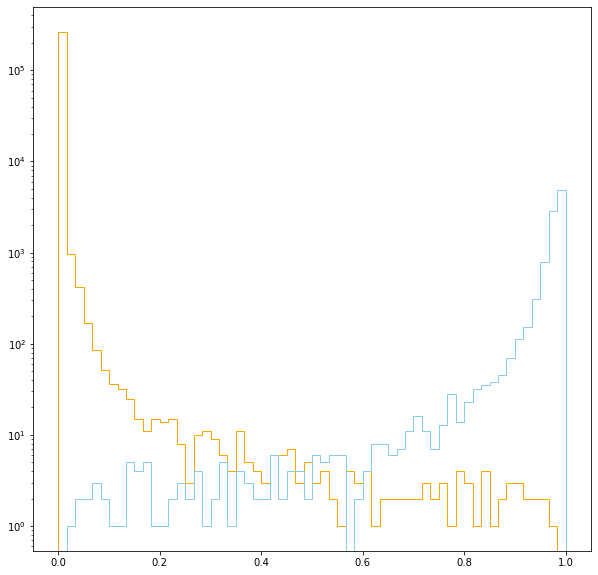

In [15]:
fig = plt.figure( figsize=(10,10) )
plt.hist( y_test_proba[ y_test == 0 ], histtype='step', color='orange', bins=60, range=(0.,1.) )
plt.hist( y_test_proba[ y_test == 1 ], histtype='step', color='skyblue', bins=60, range=(0.,1.) )
plt.yscale('log')

In [16]:
prob_cut = 0.50

y_test_pred = ( y_test_proba >= prob_cut ).astype( "int32" )
print ( y_test_pred )

from sklearn.metrics import accuracy_score
print ( accuracy_score( y_test, y_test_pred ) )
print ( accuracy_score( y_test[ y_test == 1 ], y_test_pred[ y_test == 1 ] ) )
print ( accuracy_score( y_test[ y_test == 0 ], y_test_pred[ y_test == 0 ] ) )

[0 0 0 ... 0 0 0]
0.9994700505992784
0.991984176556319
0.9997404961412905


Text(0.5, 0, 'Number of Trees')

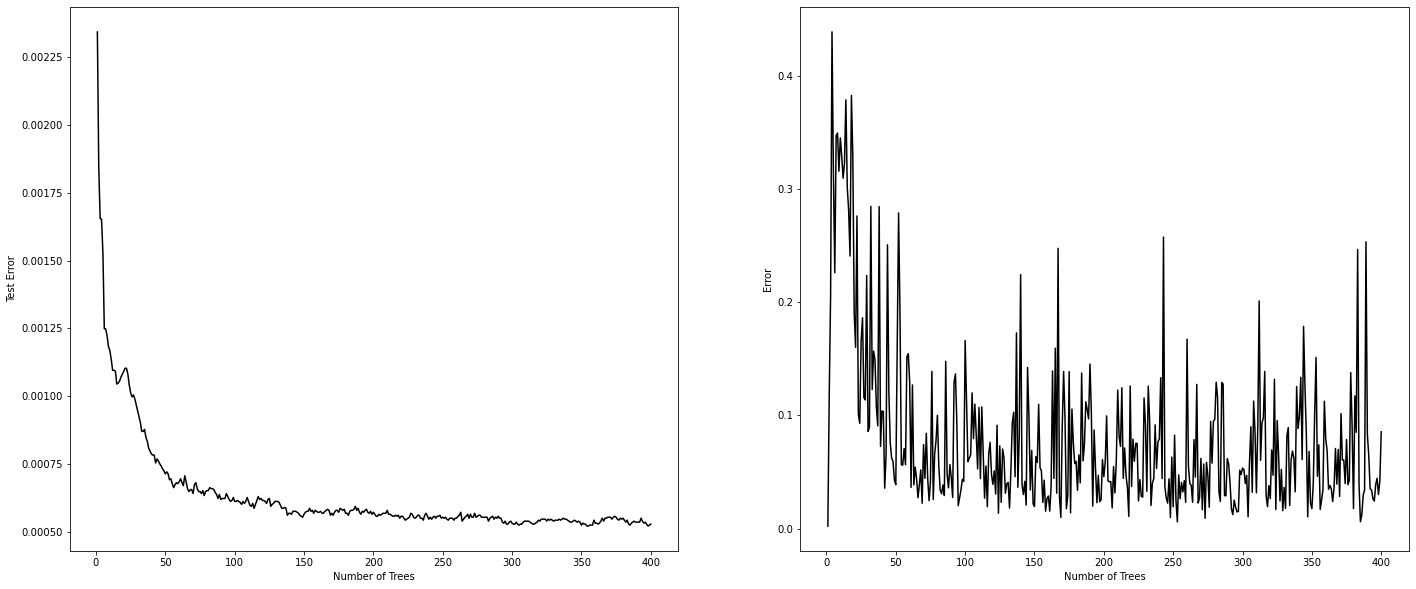

In [17]:
test_errors = []
for test_predict_proba in model_final.staged_predict_proba( X_test ):
    test_errors.append( 1. - accuracy_score( ( test_predict_proba[:,1] >= prob_cut ), y_test ) )

n_trees = len( model_final )

estimator_errors = model_final.estimator_errors_[:n_trees]

plt.figure( figsize=(24, 10) )
plt.subplot(121)
plt.plot( np.arange(1, n_trees + 1), test_errors, c='black' )
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')
#plt.ylim( 0.20, 0.50 )

plt.subplot(122)
plt.plot( np.arange(1, n_trees + 1), estimator_errors, c='black' )
plt.ylabel('Error')
plt.xlabel('Number of Trees')
#plt.ylim( 0.20, estimator_errors.max() * 1.2 )

### Save model

In [18]:
if train_model and save_model:
    dump( model_final, "model/ada_clf.joblib" )

### References

In [ ]:
from scipy.stats import uniform
np.info(uniform)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
np.info( AdaBoostClassifier )

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#np.info( RandomizedSearchCV )
print ( RandomizedSearchCV(AdaBoostClassifier(
            DecisionTreeClassifier( random_state=42 ),
            algorithm="SAMME.R"
            ),
            param_distribs)
      )